In [1]:
import random
import os
import cv2
import imutils
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from skimage.segmentation import clear_border
from imutils.perspective import four_point_transform
from collections import defaultdict
from keras.models import load_model

model = load_model('./cnn_model.h5')

In [62]:
def find_puzzle(imgPath, debug=False):
    img = cv2.imread(imgPath, cv2.CV_8UC1)
    grayimg = cv2.imread(imgPath)
    gray = cv2.cvtColor(grayimg, cv2.COLOR_BGR2GRAY)
    plt.imshow(gray, cmap="gray")
    proc = cv2.GaussianBlur(img.copy(), (9, 9), 0)
    proc = cv2.adaptiveThreshold(proc, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    proc = cv2.bitwise_not(proc, proc)
    kernel = np.array([[0., 1., 0.], [1., 1., 1.], [0., 1., 0.]], np.uint8)
    proc = cv2.dilate(proc, kernel)
    cnts = cv2.findContours(proc.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
    puzzleCnt = None
    for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        if len(approx) == 4:
            puzzleCnt = approx
            break
    if puzzleCnt is None:
        raise Exception(("Could not find Sudoku puzzle outline. "
                         "Try debugging your thresholding and contour steps."))
    puzzle = four_point_transform(img, puzzleCnt.reshape(4, 2))
    warped = four_point_transform(gray, puzzleCnt.reshape(4, 2))
    puzzle = cv2.resize(puzzle, (666, 666), interpolation=cv2.INTER_CUBIC)
    return puzzle, warped

In [63]:
def imgcrop(input, x, y):
    w, h = input.shape
    height = h // y
    width = w // x
    crop_img = defaultdict(dict)
    for i in range(0, y):
        for j in range(0, x):
            crop_img[i][j] = input[(height * i):height * (i + 1), (j * width):width * (j + 1)]
    return crop_img

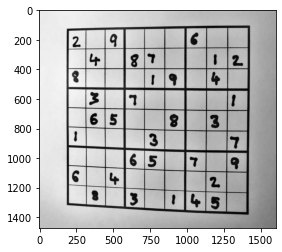

In [64]:
imgpath = './hand2.jpeg'
img = cv2.imread(imgpath)
puzzle, warped = find_puzzle(imgpath)
# plt.imshow(img)

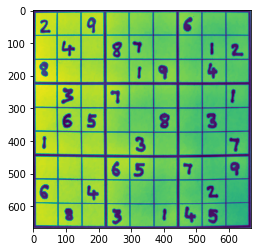

In [65]:
plt.imshow(puzzle)

In [66]:
# plt.imshow(warped)

def extract_digit(cell, flag):
    thresh = cv2.threshold(cell, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    thresh = clear_border(thresh)
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    if len(cnts) == 0:
        return 0
    c = max(cnts, key=cv2.contourArea)
    mask = np.zeros(thresh.shape, dtype="uint8")
    cv2.drawContours(mask, [c], -1, 255, -1)
    (h, w) = thresh.shape
    percentFilled = cv2.countNonZero(mask) / float(w * h)
    if percentFilled < 0.03:
        print("Little Data")
    digit = cv2.bitwise_and(thresh, thresh, mask=mask)
    img = cv2.resize(digit, (28, 28), interpolation=cv2.INTER_CUBIC)
    name = './digit_data/tmp_' + str(flag) + '.jpg'
    cv2.imwrite(name, img)
    img = cv2.imread(name, 0)
#     os.remove('tmp.jpg')    
    X = img / 255.0
    X = X.reshape(-1, 28, 28, 1)
    res = model.predict(X)
    return np.argmax(res)

In [73]:
# this is main funtion
def main():
    n = 9
    t = []
    cells = imgcrop(puzzle, n, n)
    flag = 0
    for i in range(0, n):
        r = []
        for j in range(0, n):
            r = np.append(r, extract_digit(cells[i][j], flag))
            flag = flag + 1
        t = np.append(t, r)
    r = t.reshape(9, 9)
    r = r.astype(int)
    print(r)

# This is the end of the functional code.

In [74]:
main()

[[2 0 9 0 0 0 0 0 0]
 [0 4 0 8 7 0 0 0 2]
 [8 0 0 0 0 9 0 4 0]
 [0 3 0 7 0 0 0 0 0]
 [0 8 5 0 0 8 0 3 0]
 [1 0 0 0 3 0 0 0 7]
 [0 0 0 8 5 0 7 0 8]
 [5 0 4 0 0 0 0 2 0]
 [0 3 0 3 0 5 4 5 0]]


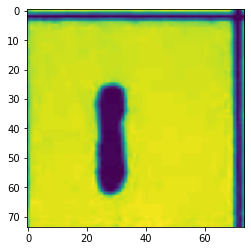

In [75]:
rowIndex = 1
colIndex = 7

plt.imshow(cells[rowIndex][colIndex])

[[9.8067987e-01 2.5820018e-05 5.4832066e-07 9.2986096e-12 2.7821985e-05
  5.8775200e-03 9.4623491e-03 2.7005639e-04 3.6559596e-03 1.4798835e-07]]


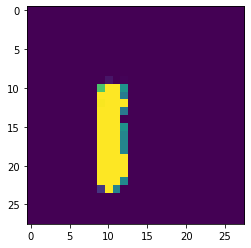

In [76]:
cell = cells[rowIndex][colIndex]
thresh = cv2.threshold(cell, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
thresh = clear_border(thresh)
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
if len(cnts) == 0:
    print('No image')
c = max(cnts, key=cv2.contourArea)
mask = np.zeros(thresh.shape, dtype="uint8")
cv2.drawContours(mask, [c], -1, 255, -1)
(h, w) = thresh.shape
percentFilled = cv2.countNonZero(mask) / float(w * h)
if percentFilled < 0.03:
    print('Little Data')
digit = cv2.bitwise_and(thresh, thresh, mask=mask)
img = cv2.resize(digit, (28, 28), interpolation=cv2.INTER_CUBIC)
X = img / 255
X = X.reshape(-1, 28, 28, 1)
res = model.predict(X)
print(res)
plt.imshow(img)


In [77]:
np.argmax(res[0])

0

In [12]:
# cells
# plt.figure(figsize=(18,18))
# for i in range(81):
#     plt.subplot(9, 9, i+1)
#     plt.xticks([])
#     plt.yticks([])
#     plt.grid('off')
#     plt.imshow(cells[i], cmap=plt.cm.binary)
# #     plt.xlabel(str(round(max((res[n]) * 100), 2)) + "%- Pred: " + str(np.argmax(res[j])))